In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def file_path(question, ext):
    """
    This Function will be used to specify the csv file of the imported database
    ----
    Parameters :
    1. questions : String -> This is the Question that will be promt user to input file
    2. extension : String -> Allowed file extension, in this case is csv
    """
    while True:
        try:
            file = Path(input(question))
            if file.exists() and file.is_file and file.suffix in ext:
                return file
        except:
            print('File not suitable, please retry')

## INPUT Dataset
MOD Data Historical from 2022 to 2025

In [2]:
csv = file_path('Masukkan File CSV  : ','.csv')
dataset = pd.read_csv(csv)
dataset


Masukkan File CSV  :  BGLData_PandasAnum.csv
Masukkan File CSV  :  BGLData_PandasAnumA.csv


Year     OB (Bcm)  Coal (Ton)  Distance OB (KM)  Distance Coal (KM)  \
0  2022   82211454.0     8427181          3.180433            3.123036   
1  2023  117236174.0     9760000          2.958000            3.425481   
2  2024  103353356.0    10799812          3.506708            3.935034   
3  2025  100561816.3    11200000          3.226990            4.015620   

          Fuel  
0  135367220.0  
1  162815964.0  
2  160640375.0  
3  157948713.4

## Checking for Linearity
Before you execute a linear regression model, it is advisable to validate that certain assumptions are met.
To perform a quick linearity check, we can use scatter diagrams (utilizing the matplotlib library).

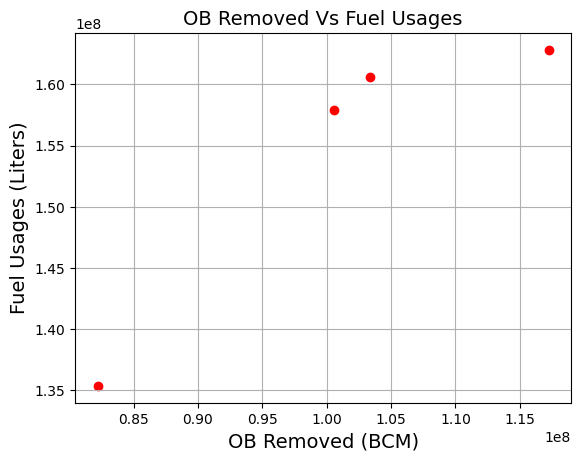

In [3]:
plt.scatter(dataset['OB (Bcm)'], dataset['Fuel'], color='red')
plt.title('OB Removed Vs Fuel Usages', fontsize=14)
plt.xlabel('OB Removed (BCM)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

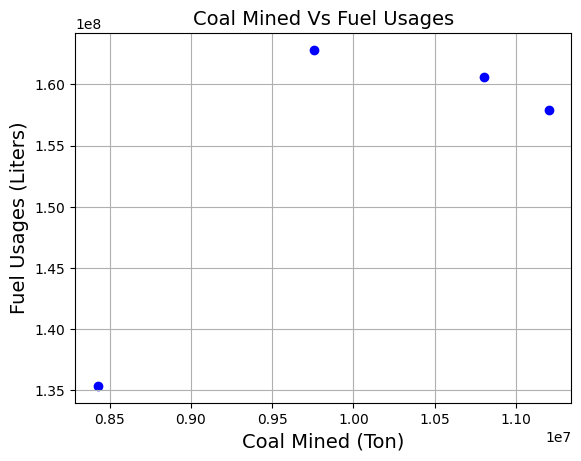

In [4]:
plt.scatter(dataset['Coal (Ton)'], dataset['Fuel'], color='blue')
plt.title('Coal Mined Vs Fuel Usages', fontsize=14)
plt.xlabel('Coal Mined (Ton)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

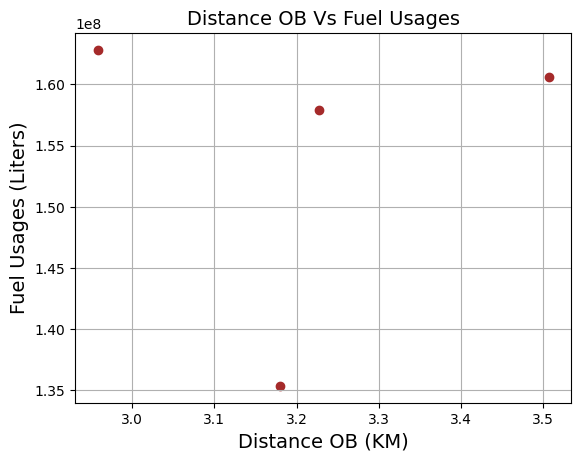

In [5]:
plt.scatter(dataset['Distance OB (KM)'], dataset['Fuel'], color='brown')
plt.title('Distance OB Vs Fuel Usages', fontsize=14)
plt.xlabel('Distance OB (KM)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

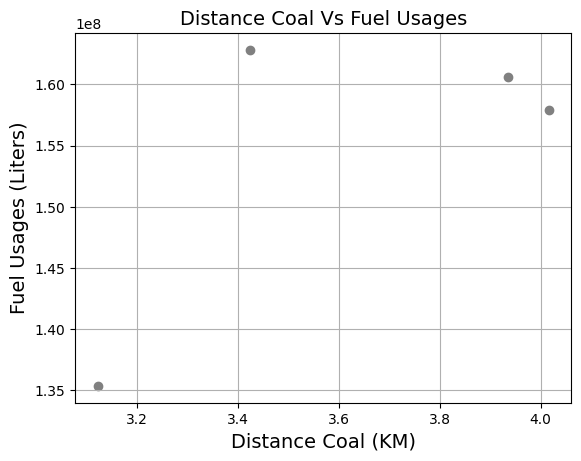

In [6]:
plt.scatter(dataset['Distance Coal (KM)'], dataset['Fuel'], color='gray')
plt.title('Distance Coal Vs Fuel Usages', fontsize=14)
plt.xlabel('Distance Coal (KM)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

## From Linearity test above we found that OB Removed, and Coal (Ton) have linier relantionship with Fuel Usages

In [7]:
dataset = dataset.drop(['Year'], axis=1)

In [8]:
correlations = dataset.corr()
correlations['Fuel'].round(2)

OB (Bcm)              0.92
Coal (Ton)            0.79
Distance OB (KM)      0.04
Distance Coal (KM)    0.69
Fuel                  1.00
Name: Fuel, dtype: float64

## From Corelation above 
We found that OB, Coal & Distance OB have corelation to Fuel, which have corelation point >= 0.2

In [9]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, LeaveOneOut
import statsmodels.api as sm
import seaborn as sns

## Checking Outliers

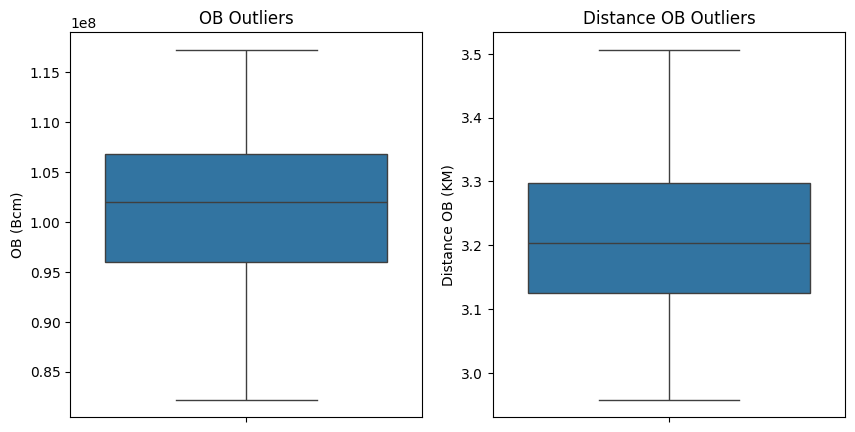

In [10]:
# Create box plots for each feature
plt.figure(figsize=(10, 5))

# OB Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(y=dataset['OB (Bcm)'])
plt.title("OB Outliers")

# Coal Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=dataset['Distance OB (KM)'])
plt.title("Distance OB Outliers")

plt.show()

In [11]:
# Compute IQR
Q1 = dataset[['OB (Bcm)', 'Distance OB (KM)']].quantile(0.25)
Q3 = dataset[['OB (Bcm)', 'Distance OB (KM)']].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((dataset[['OB (Bcm)', 'Distance OB (KM)']] < lower_bound) | (dataset[['OB (Bcm)', 'Distance OB (KM)']] > upper_bound))

# Get row indices of outliers
outlier_indices = dataset[outliers.any(axis=1)].index
outlier_masks = dataset[outliers.any(axis=1)]
print("Outlier indices:", outlier_indices)

outlier_rows = dataset.loc[outlier_indices]
print(outlier_rows)

Outlier indices: Index([], dtype='int64')
Empty DataFrame
Columns: [OB (Bcm), Coal (Ton), Distance OB (KM), Distance Coal (KM), Fuel]
Index: []


## Clean Dataset without Outliers

In [12]:
dataset = dataset.drop(index=outlier_indices)  # Keep only rows without outliers
dataset

OB (Bcm)  Coal (Ton)  Distance OB (KM)  Distance Coal (KM)         Fuel
0   82211454.0     8427181          3.180433            3.123036  135367220.0
1  117236174.0     9760000          2.958000            3.425481  162815964.0
2  103353356.0    10799812          3.506708            3.935034  160640375.0
3  100561816.3    11200000          3.226990            4.015620  157948713.4

In [13]:
correlations = dataset.corr()
correlations['Fuel'].round(2)

OB (Bcm)              0.92
Coal (Ton)            0.79
Distance OB (KM)      0.04
Distance Coal (KM)    0.69
Fuel                  1.00
Name: Fuel, dtype: float64

## Features & Target
Features (x) : Independent Variables = OB and Coal
Target (y) : Dependent Variable = Fuel

In [14]:
x = dataset[['OB (Bcm)','Coal (Ton)','Distance Coal (KM)']]
y = dataset['Fuel']
 
# Split dataset (70% Train, 30% Test) For Evaluation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [15]:
# ==============================
# Linear Regression (sklearn)
# ==============================
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [16]:
# Predictions
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

In [17]:
# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Cross-Validation (2-fold)
#kf = KFold(n_splits=1, shuffle=True, random_state=42)
#loo = LeaveOneOut()
#cv_scores = cross_val_score(regr, X_train, y_train, cv=kf, scoring='r2')

# Print Results
print("\n Model Performance Metrics:")
print(f"Train MSE: {train_mse:.3f} | Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f} | Test MAE: {test_mae:.3f}")
print(f"Train RÂ² Score: {train_r2:.3f} | Test RÂ² Score: {test_r2:.3f}")

#print("\n Cross-Validation Results:")
#print(f"RÂ² Scores for each fold: {cv_scores.round(3)}")
#print(f"Mean RÂ² Score: {cv_scores.mean():.3f} | Std Dev: {cv_scores.std():.3f}")


 Model Performance Metrics:
Train MSE: 0.000 | Test MSE: 145689494504989.281
Train MAE: 0.000 | Test MAE: 12070190.326
Train RÂ² Score: 1.000 | Test RÂ² Score: nan


C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [18]:
# ==============================
# Linear Regression (statsmodels)
# ==============================
regr = linear_model.LinearRegression()
regr.fit(x, y)
print("Final Model Intercept:", regr.intercept_.round(3))
print("Final Model Coefficients:", regr.coef_.round(3))

X_const = sm.add_constant(x)  # Add constant for intercept
model = sm.OLS(y, X_const).fit()
print("\nðŸ“Œ Statsmodels Regression Summary:")
print(model.summary())

Final Model Intercept: 31901304.859
Final Model Coefficients: [ 7.96000000e-01 -7.94700000e+00  3.36261881e+07]

ðŸ“Œ Statsmodels Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                   Fuel   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Jul 2025   Prob (F-statistic):                nan
Time:                        16:58:43   Log-Likelihood:                 53.665
No. Observations:                   4   AIC:                            -99.33
Df Residuals:                       0   BIC:                            -101.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|

C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define features (exclude 'Fuel' since it's the target variable)
features = ['OB (Bcm)','Distance OB (KM)','Distance Coal (KM)']
X = dataset[features]  

# Add a constant column for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature         VIF
0               const  592.416114
1            OB (Bcm)    2.034374
2    Distance OB (KM)    2.607320
3  Distance Coal (KM)    2.759463


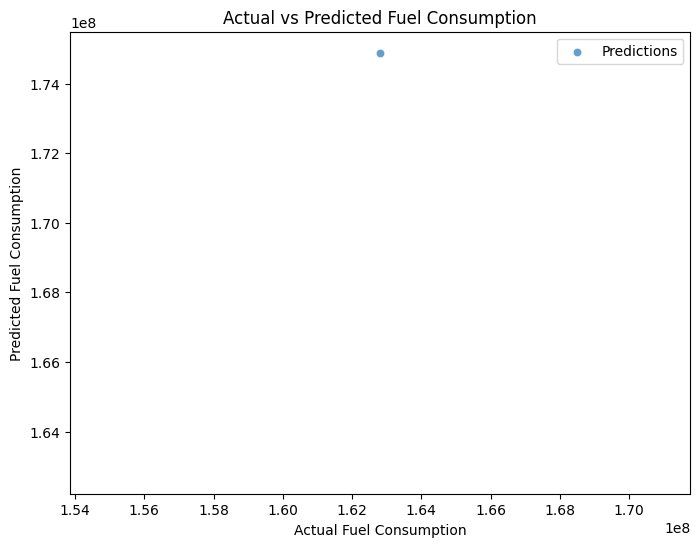

In [20]:
# ==============================
# Plot: Actual vs Predicted
# ==============================
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fuel Consumption")
plt.ylabel("Predicted Fuel Consumption")
plt.title("Actual vs Predicted Fuel Consumption")
plt.legend()
plt.show()